## Topic: Sentiment Analysis on Conversational Data
Import required packages

In [4]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from collections import Counter
from tqdm import tqdm, tqdm_notebook
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

In [5]:
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.utils.multiclass import unique_labels

In [6]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, ConvLSTM2D, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.utils import to_categorical
from keras import optimizers
import keras.backend as K

Using TensorFlow backend.


## Data Import

In [12]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','test_sent_emo.csv'))

In [13]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


## Labels Distribution

Text(0.5,1,'testing set')

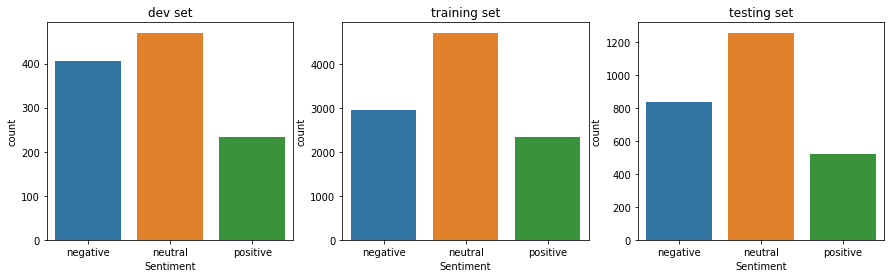

In [14]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='Sentiment', data=dev_raw, ax=axes[0], order=['negative','neutral','positive']).set_title('dev set')
sns.countplot(x='Sentiment', data=train_raw, ax=axes[1], order=['negative','neutral','positive']).set_title('training set')
sns.countplot(x='Sentiment', data=test_raw, ax=axes[2], order=['negative','neutral','positive']).set_title('testing set')

In [15]:
print(Counter(dev_raw.Sentiment))
print(Counter(train_raw.Sentiment))
print(Counter(test_raw.Sentiment))

Counter({'neutral': 470, 'negative': 406, 'positive': 233})
Counter({'neutral': 4710, 'negative': 2945, 'positive': 2334})
Counter({'neutral': 1256, 'negative': 833, 'positive': 521})


In [16]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

Text(0.5,1,'train+test set')

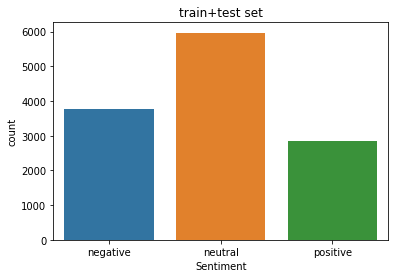

In [17]:
train_raw['source'] = 'train'
test_raw['source'] = 'test'
data_raw = pd.concat([train_raw, test_raw])
data_raw.shape
sns.countplot(x='Sentiment', data=data_raw, order=['negative','neutral','positive']).set_title('train+test set')

## Resampling  
To deal with imbalanced datasets.

In [18]:
count_neutral, count_negative, count_positive = data_raw.Sentiment.value_counts()
print(f'There are {count_negative} negative, {count_neutral} neutral and {count_positive} positive utternaces.')

There are 3778 negative, 5966 neutral and 2855 positive utternaces.


In [19]:
tmp_df_negative = data_raw[data_raw.Sentiment == 'negative']
tmp_df_neutral = data_raw[data_raw.Sentiment == 'neutral']
tmp_df_positive = data_raw[data_raw.Sentiment == 'positive']

tmp_df_negative_undersampled = tmp_df_negative.sample(floor(count_positive*1.1)).reset_index(drop=True)
tmp_df_neutral_undersampled = tmp_df_neutral.sample(floor(count_positive*0.95)).reset_index(drop=True)

In [20]:
data_balanced = pd.concat([tmp_df_negative_undersampled, tmp_df_neutral_undersampled, tmp_df_positive], axis=0)
data_balanced = shuffle(data_balanced)
data_balanced.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,source
2375,2514,Wow! It's huge! It's so much bigger than the c...,Phoebe,surprise,positive,250,0,1,15,"00:14:57,771","00:15:05,945",train
164,67,Oh.,Phoebe,neutral,neutral,7,1,3,24,"00:03:28,875","00:03:30,459",test
8577,9027,Speech! Come on Monica!,Mrs. Geller,joy,positive,902,12,7,14,"0:15:04,194","0:15:05,416",train
4080,4302,Hey he's wearing a sweater.,Rachel,surprise,positive,440,9,1,14,"00:13:33,729","00:13:35,188",train
7736,8147,That's it?! I gave up my,Chandler,joy,positive,819,17,7,4,"00:07:02,672","00:07:05,757",train


There are 3140 negative, 2712 neutral and 2855 positive utternaces.


Text(0.5,1,'rebalanced set')

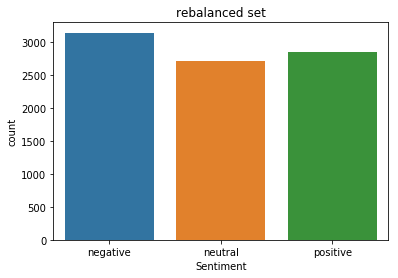

In [21]:
new_c_negative, new_c_positive, new_c_neutral = data_balanced.Sentiment.value_counts()
print(f'There are {new_c_negative} negative, {new_c_neutral} neutral and {new_c_positive} positive utternaces.')
sns.countplot(x='Sentiment', data=data_balanced, order=['negative','neutral','positive']).set_title('rebalanced set')

In [22]:
print(f'Ratio: {round(100*new_c_negative/len(data_balanced),0)}% negative, {round(100*new_c_neutral/len(data_balanced),0)}% neutral and {round(100*new_c_positive/len(data_balanced),0)}% positive utternaces.')

Ratio: 36.0% negative, 31.0% neutral and 33.0% positive utternaces.


## Extra testing set  
The label imbalancing issue only concerns the training set. For a good classifier, it should be able to accept and predict correctly a test set with any label distribution.  Hence using the rest of the data that are not in the resample set as an extra test set.

In [23]:
data_diff = pd.concat([data_balanced[['Utterance','Sentiment']],data_raw[['Utterance','Sentiment']]]).drop_duplicates(keep=False)

12599 in raw, 8707 in balanced, 3413 in diff.


Text(0.5,1,'rebalanced set')

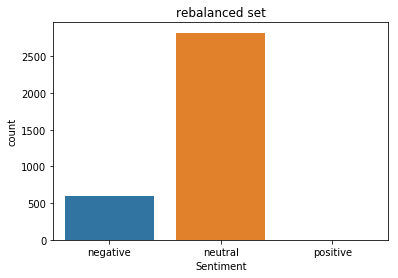

In [24]:
print(f'{len(data_raw)} in raw, {len(data_balanced)} in balanced, {len(data_diff)} in diff.')
sns.countplot(x='Sentiment', data=data_diff, order=['negative','neutral','positive']).set_title('rebalanced set')

## Word Count Distribution
Remove punctuations & special symbols

In [25]:
unwanted_pattern = r'[^A-z0-9\s]'
data_balanced['text'] = data_balanced.Utterance.apply(lambda u: re.sub(unwanted_pattern, '', u))

In [26]:
data_balanced[['Utterance', 'text']].head()

,Utterance,text
2375,Wow! It's huge! It's so much bigger than the c...,Wow Its huge Its so much bigger than the cubic...
164,Oh.,Oh
8577,Speech! Come on Monica!,Speech Come on Monica
4080,Hey he's wearing a sweater.,Hey hes wearing a sweater
7736,That's it?! I gave up my,Thats it I gave up my


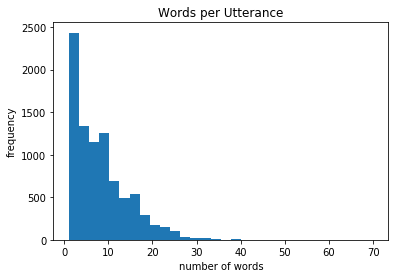

In [27]:
word_count = [len(t.split(' ')) for t in data_balanced.text]
plt.hist(word_count, bins=30, range=[1,70])
plt.title('Words per Utterance')
plt.ylabel('frequency')
plt.xlabel('number of words')
plt.show()

In [28]:
print(f"On average the dataset has {round(sum(word_count)/len(word_count))} words per utterance.")

On average the dataset has 8 words per utterance.


## Lemmatisation

In [29]:
import nltk
nltk.download('punkt')
porter = PorterStemmer()
snowball = SnowballStemmer("english")

def stemSentence(sentence, stemmer):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
    return " ".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
utterances = data_balanced.Utterance.values
utterances_stem = [stemSentence(sentence, snowball) for sentence in utterances]

Apply the same procedure to the extra testing set

In [31]:
utterances_stem_ex = [stemSentence(sentence, snowball) for sentence in data_diff.Utterance.values]

## Preprocessing (deep learning)

In [32]:
print('The longest utterance contains {} words.'.format(max([len(x.split(' ')) for x in data_balanced.Utterance])))

The longest utterance contains 45 words.


In [33]:
# For sentiment analysis
num_polarities = 3
max_sequence_len = 100

vocabulary_size = 6000
tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{}~', lower=True, )
tokenizer.fit_on_texts(utterances_stem)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4177 unique tokens.


In [34]:
X = tokenizer.texts_to_sequences(utterances_stem)
X = pad_sequences(X, maxlen=max_sequence_len)
print('Shape of data tensor:', X.shape)

# X = tokenizer.texts_to_matrix(data_balanced.Utterance, mode='tfidf')
# print('Shape of data tensor:', X.shape)
# X[0]

Shape of data tensor: (8707, 100)


In [35]:
y = data_balanced.Sentiment.values
sen_targets, sen_uniques = pd.factorize(y, sort=True)
y = to_categorical(sen_targets, num_polarities)

In [36]:
sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Apply the same procedure to the extra testing set

In [59]:
X_ex = tokenizer.texts_to_sequences(utterances_stem_ex)
X_test_ex = pad_sequences(X_ex, maxlen=max_sequence_len)
print('Shape of data tensor:', X_test_ex.shape)

Shape of data tensor: (3393, 100)


In [60]:
y_ex = data_diff.Sentiment.values
ex_targets = np.vectorize(sen_label_map.get)(y_ex)
y_test_ex = to_categorical(ex_targets, num_polarities)

In [61]:
y_test_ex

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

## Preprocessing (supervised learning)  
To avoid naming conflict, the x_train, y_train used in supervised learning will be represented by p_train, q_train

In [38]:
num_polarities=3
P = utterances_stem
Q = data_balanced.Sentiment.values

q, uniques = pd.factorize(Q, sort=True)
label_map = dict(zip(list(uniques), range(num_polarities)))
label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

### TF-IDF Tokenizer

In [39]:
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(P)
p = tfidf.transform(P)

### Truncated SVD  
To reduce the dimension of the features

In [35]:
def plot_svd(n_comp_list, data):
    var_explained=[]
    for n in n_comp_list:
        svd = TruncatedSVD(n_components=n)
        svd.fit(data)
        var_explained.append(svd.explained_variance_ratio_.sum())
    plt.plot(n_comp_list, var_explained)
    plt.ylabel('variance explained')
    plt.xlabel('number of components')
    plt.title('Selecting n_components')
    plt.grid(True)
    plt.show()

Sometimes, var_explained >= 0.9 or var_explained >= 0.95 reduces how many variables you need going forward in your analysis.

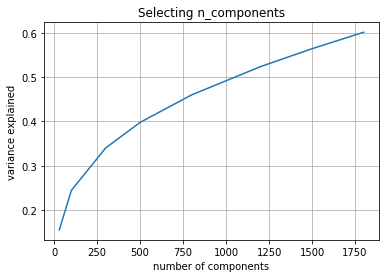

In [27]:
plot_svd(n_comp_list=[30,100,300,500,800,1200,1500,1800], data=p)

In [116]:
svd = TruncatedSVD(n_components=500)
p_svd = svd.fit_transform(p)

Apply the same procedure to the extra test set

In [37]:
p_ex = tfidf.transform(utterances_stem_ex)
p_test_ex = svd.transform(p_ex)

In [38]:
q_ex = data_diff.Sentiment.values
q_test_ex = np.vectorize(label_map.get)(q_ex)

## Factory functions
### Cross-validation with Stratified K-fold

In [39]:
def predict_with_cv(clf, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, random_state=42)
    acc_collector=[]
    nth_fold = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X=X_train, y=y_train)
        y_pred = clf.predict(X_test)
        acc = round(100*np.sum(y_pred==y_test)/len(y_pred),2)
        nth_fold += 1
        acc_collector.append(acc)
        print('Fold {}: F1 score = {}; Test ccuracy = {}%'.format(
            nth_fold, f1_score(y_pred=y_pred, y_true=y_test, average="weighted"), acc))
    print('Average accuracy over {} folds is {}%'.format(n_splits, sum(acc_collector)/len(acc_collector)))

### Ploting deep learning val_loss against epoch

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()

### Plotting Confusion Matrix

In [112]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Models  
**Summary on Sentiment Analysis**  
Predicting 3 classes: Positive, Negative & Neutral   
  
**Models ready at disposal:**  
- SVM  
- Random Forest
- Fully connected (Dense only)  
- CNN  
- Transfer learning with Glove + LSTM

**Accuracy records** 
- Benchmart(Base): 36.06%
- SVM: 49.63%  
- Random Forest: 47.33%
- Dense: 36.88%
- CNN: 38.03%  
- LSTM (with Glove): 42%  

*NB: there might be a ceiling on how much you can achieve with the data*

### Baseline
A simplest model that will predict the same class for any given sentences/utterances.

In [50]:
class BaseModel():
    def __init__(self):
        self.pred=None
        
    def fit(self, X, y):
        self.pred = Counter(y).most_common()[0][0]
        
    def predict(self, x_test):
        return x_test.shape[0] * [self.pred]

In [45]:
base_model = BaseModel()
predict_with_cv(base_model, X=p, y=q, n_splits=5)

Fold 1: F1 score = 0.19105252704345846; Test ccuracy = 36.05%
Fold 2: F1 score = 0.19105252704345846; Test ccuracy = 36.05%
Fold 3: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Fold 4: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Fold 5: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Average accuracy over 5 folds is 36.062%


/Users/cheuky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Support Vector Machine (SVM)

In [117]:
svm = SVC(C=10, kernel='linear', probability=True, random_state=42)

In [29]:
# param_grid_svm = { 
#     'C': [1,10,100], 'kernel': ['linear', 'rbf']
# }
# clf = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5)
# clf.fit(x_train_tr, y_train)

In [ ]:
# clf.best_estimator_

**Best model by GridSearchCV**  
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,  
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',  
kernel='linear', max_iter=-1, probability=True, random_state=None,  
shrinking=True, tol=0.001, verbose=False)

In [51]:
# svm_accuracy = 100*np.sum(y_pred_svm==q_test)/len(y_pred_svm)
# print('Test accuracy: %.4f%%' % svm_accuracy)

In [30]:
predict_with_cv(svm, X=p_svd, y=q, n_splits=5)

Fold 1: F1 score = 0.4962186249534722; Test ccuracy = 50.34%
Fold 2: F1 score = 0.4782719839250737; Test ccuracy = 48.22%
Fold 3: F1 score = 0.4815661531107952; Test ccuracy = 48.48%
Fold 4: F1 score = 0.47462396054127426; Test ccuracy = 48.08%
Fold 5: F1 score = 0.48492597308789737; Test ccuracy = 48.94%
Average accuracy over 5 folds is 48.812%


__SVD n_components=300:__  
Fold 1: F1 score = 0.4803915716898258; Test ccuracy = 48.91%  
Fold 2: F1 score = 0.4542740225417006; Test ccuracy = 46.84%  
Fold 3: F1 score = 0.48864408148921173; Test ccuracy = 49.91%  
Fold 4: F1 score = 0.4892975093190058; Test ccuracy = 50.32%  
Fold 5: F1 score = 0.4784412899435637; Test ccuracy = 49.22%  
Average accuracy over 5 folds is 49.04%  
  
__SVD n_components=500:__  
Fold 1: F1 score = 0.49002215752622763; Test ccuracy = 49.77%  
Fold 2: F1 score = 0.4808583429948203; Test ccuracy = 49.2%  
Fold 3: F1 score = 0.4874187290127619; Test ccuracy = 49.34%  
Fold 4: F1 score = 0.4944249992907478; Test ccuracy = 50.03%  
Fold 5: F1 score = 0.4919448080783031; Test ccuracy = 49.8%  
Average accuracy over 5 folds is 49.628%  
  
__SVD n_components=800:__  
Fold 1: F1 score = 0.46966213004635426; Test ccuracy = 47.3%  
Fold 2: F1 score = 0.4711375764871562; Test ccuracy = 47.65%  
Fold 3: F1 score = 0.4928203326071507; Test ccuracy = 49.74%  
Fold 4: F1 score = 0.4823228281974452; Test ccuracy = 48.54%  
Fold 5: F1 score = 0.4761281720634562; Test ccuracy = 48.02%  
Average accuracy over 5 folds is 48.25%  

In [99]:
predict_with_cv(svm, X=p_test_ex, y=q_test_ex, n_splits=5)

Fold 1: F1 score = 0.7764287876963933; Test ccuracy = 82.37%
Fold 2: F1 score = 0.7836334344208311; Test ccuracy = 82.94%
Fold 3: F1 score = 0.7780162097534926; Test ccuracy = 82.94%
Fold 4: F1 score = 0.7758909706355496; Test ccuracy = 82.76%
Fold 5: F1 score = 0.7722856244847532; Test ccuracy = 83.21%
Average accuracy over 5 folds is 82.844%


In [125]:
p_train, p_test, q_train, q_test = train_test_split(p_svd, q, test_size = 0.33, random_state = 42)
svm.fit(X=p_train, y=q_train)
y_pred_svm = svm.predict(p_test)

Confusion matrix, without normalization
[[648 244 138]
 [374 357 167]
 [340 232 374]]


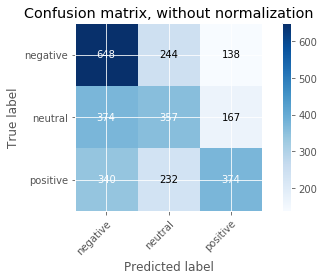

In [126]:
plot_confusion_matrix(y_true=q_test, y_pred=y_pred_svm, classes=uniques)

### Random Forest

In [113]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, min_samples_split=4,
                            criterion='gini', max_features='auto')

In [29]:
predict_with_cv(clf=rf, X=p_svd, y=q, n_splits=5)

Fold 1: F1 score = 0.47461706544641874; Test ccuracy = 48.97%
Fold 2: F1 score = 0.456600241551185; Test ccuracy = 46.44%
Fold 3: F1 score = 0.4523886385518907; Test ccuracy = 46.3%
Fold 4: F1 score = 0.4738436999013484; Test ccuracy = 48.71%
Fold 5: F1 score = 0.48235998563306615; Test ccuracy = 48.77%
Average accuracy over 5 folds is 47.838%


__SVD n_components=300:__  
Fold 1: F1 score = 0.4821594130439804; Test ccuracy = 49.02%  
Fold 2: F1 score = 0.4457256160906289; Test ccuracy = 45.52%  
Fold 3: F1 score = 0.4799812863744916; Test ccuracy = 48.59%  
Fold 4: F1 score = 0.4742767830904166; Test ccuracy = 48.42%  
Fold 5: F1 score = 0.4626270907058054; Test ccuracy = 47.33%  
Average accuracy over 5 folds is 47.78%  
  
__SVD n_components=500:__  
Fold 1: F1 score = 0.4563487257822179; Test ccuracy = 46.84%  
Fold 2: F1 score = 0.47949307279503584; Test ccuracy = 49.31%  
Fold 3: F1 score = 0.48139907627684986; Test ccuracy = 49.28%  
Fold 4: F1 score = 0.4600893431558319; Test ccuracy = 47.04%  
Fold 5: F1 score = 0.4569176293258227; Test ccuracy = 47.04%  
Average accuracy over 5 folds is 47.902%  
  
__SVD n_components=800:__  
Fold 1: F1 score = 0.47376694097558875; Test ccuracy = 48.39%  
Fold 2: F1 score = 0.4360728461345362; Test ccuracy = 44.72%  
Fold 3: F1 score = 0.4658015840886764; Test ccuracy = 47.33%  
Fold 4: F1 score = 0.46356914367324187; Test ccuracy = 47.73%  
Fold 5: F1 score = 0.44157950564388676; Test ccuracy = 45.61%  
Average accuracy over 5 folds is 46.76%  

In [101]:
predict_with_cv(clf=rf, X=p_test_ex, y=q_test_ex, n_splits=5)

Fold 1: F1 score = 0.7687798915256568; Test ccuracy = 83.56%
Fold 2: F1 score = 0.7659402141195129; Test ccuracy = 83.53%
Fold 3: F1 score = 0.7559324546119501; Test ccuracy = 82.64%
Fold 4: F1 score = 0.7592426002553393; Test ccuracy = 83.06%
Fold 5: F1 score = 0.7573091270272153; Test ccuracy = 83.21%
Average accuracy over 5 folds is 83.2%


In [52]:
# param_grid_rf = { 
#     'n_estimators': [1,10,100],
#     'min_samples_split': [2, 4],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# clf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5)
# clf.fit(p_train, q_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 100], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
# clf.best_estimator_

**Best model by GridSearchCV**  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',  
            max_depth=None, max_features='auto', max_leaf_nodes=None,  
            min_impurity_decrease=0.0, min_impurity_split=None,  
            min_samples_leaf=4, min_samples_split=4,  
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,  
            oob_score=False, random_state=None, verbose=0,  
            warm_start=False)

In [120]:
p_train, p_test, q_train, q_test = train_test_split(p_svd, q, test_size = 0.33, random_state = 42)
rf.fit(X=p_train, y=q_train)
y_pred_rf = rf.predict(p_test)
# f1_score(y_pred=y_pred_rf, y_true=q_test, average="weighted")
# rf_accuracy = 100*np.sum(y_pred_rf==q_test)/len(y_pred_rf)
# print('Test accuracy: %.4f%%' % rf_accuracy)

Confusion matrix, without normalization
[[705 160 165]
 [446 267 185]
 [378 172 396]]


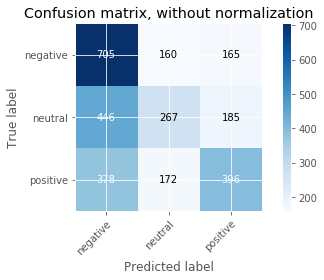

In [124]:
plot_confusion_matrix(y_true=q_test, y_pred=y_pred_rf, classes=uniques)

### Keras TF-IDF tokenizer + Neural nets

Neural network won't accept sentences with different dimension(i.e. number of words) as input. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end.  
*Ref_1* https://keras.io/preprocessing/sequence/  
*Ref_2* https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
#### Dense - Fully Connected Layers

__Early Stopping__: Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better.

We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.

In [41]:
dense_epochs=100
dense_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [42]:
def build_dense(num_classes, show=True):
    dense = Sequential()
    dense.add(Dense(32, activation='relu', input_dim=max_sequence_len))
    dense.add(Dropout(0.2))
    dense.add(Dense(64, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(128, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(num_classes, activation='softmax'))
    dense.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if show:
        print(dense.summary())
    return dense

In [26]:
dense = build_dense(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total para

The validation_split is a value between 0 and 1 and defines the percentage amount of the training dataset to use for the validation dataset.

In [27]:
dense_history=dense.fit(x_train, y_train, validation_split=0.4, epochs=dense_epochs, callbacks=[dense_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/100
3499/3499 [==============================] - 3s 876us/step - loss: 1.2716 - acc: 0.3444 - val_loss: 1.1472 - val_acc: 0.3526
Epoch 2/100
3499/3499 [==============================] - 1s 310us/step - loss: 1.1820 - acc: 0.3447 - val_loss: 1.1354 - val_acc: 0.3436
Epoch 3/100
3499/3499 [==============================] - 1s 294us/step - loss: 1.1631 - acc: 0.3492 - val_loss: 1.1417 - val_acc: 0.3470
Epoch 4/100
3499/3499 [==============================] - 1s 304us/step - loss: 1.1396 - acc: 0.3487 - val_loss: 1.1265 - val_acc: 0.3496
Epoch 5/100
3499/3499 [==============================] - 1s 303us/step - loss: 1.1215 - acc: 0.3701 - val_loss: 1.1207 - val_acc: 0.3483
Epoch 6/100
3499/3499 [==============================] - 1s 294us/step - loss: 1.1290 - acc: 0.3584 - val_loss: 1.1292 - val_acc: 0.3483
Epoch 7/100
3499/3499 [==============================] - 1s 322us/step - loss: 1.1202 - acc: 0.3641 - val_loss: 1.1088 - val_acc: 

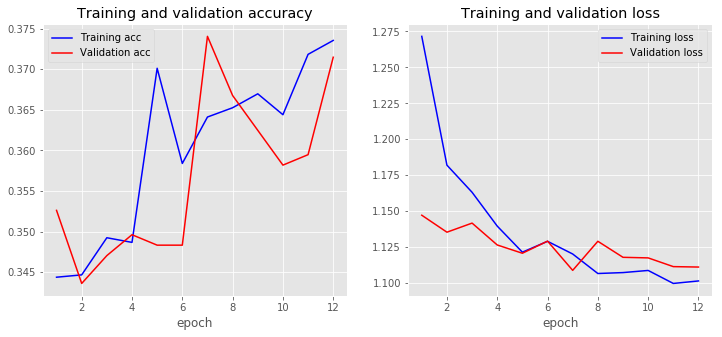

In [31]:
plot_history(dense_history)

Load the best weights saved during training

In [34]:
dense = build_dense(num_polarities, show=False)
dense.load_weights(os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'))

In [33]:
y_pred_dense = dense.predict_classes(x_test)
Counter(y_pred_dense)

2874/2874 [==============================] - 0s 76us/step


Counter({2: 1018, 0: 1664, 1: 192})

In [34]:
dense_accuracy = dense.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

2874/2874 [==============================] - 0s 37us/step
Test accuracy: 36.8824%


Test on the extra testing set

In [35]:
Counter(dense.predict_classes(X_test_ex))

Counter({0: 2225, 2: 963, 1: 188})

In [37]:
dense_accuracy = dense.evaluate(X_test_ex, y_test_ex, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

3376/3376 [==============================] - 0s 8us/step
Test accuracy: 16.8543%


__Note: About batch_size__  
Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

- Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

- The smaller the batch the less accurate the estimate of the gradient will be.

### CNN - Convolutional Layers
**Conv1D:** is generally good for text, whereas Conv2D is good for audio and images where spatial matter;  

**Max pooling:** is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing it’s dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.  

**Batch Normalization:** normalization (shifting inputs to zero-mean and unit variance) is often used as a pre-processing step to make the data comparable across features. This therefore leads to higher learning rate and better speed.  

**Drop out:** Its a regularization function that reduces/prevents overfitting, by normalizing some pixels to 0. However, it is suggested to not include a dropout layer right before the last layer as it can result in a situation where the network has no ability to "correct" errors induced by dropout before the classification happens. 

In [65]:
n_length = x_train.shape[0]
n_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(n_length, n_features, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], n_features, 1)
X_test_ex_reshaped = X_test_ex.reshape(X_test_ex.shape[0], n_features, 1)

In [44]:
cnn_epochs=60
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models', 'text', 'cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [52]:
def build_CNN(num_classes, show=True):
    cnn = Sequential()
    cnn.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(max_sequence_len,1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(GlobalAveragePooling1D())
#     cnn.add(Flatten())
    cnn.add(Dense(128, kernel_regularizer=l2(0.01)))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Dense(64, kernel_regularizer=l2(0.01)))
    cnn.add(Activation('relu'))
#     cnn.add(Dropout(0.2))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    if show:
        print(cnn.summary())
    return cnn

In [53]:
cnn = build_CNN(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 100, 16)           48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 25, 64)            4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
__________

In [54]:
!rm './saved_models/text/cnn.weights.best.hdf5'
cnn_history=cnn.fit(x_train_reshaped, y_train, validation_split=0.4,
                    epochs=cnn_epochs, callbacks=[cnn_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/60
3499/3499 [==============================] - 2s 444us/step - loss: 2.7922 - acc: 0.3512 - val_loss: 2.3678 - val_acc: 0.3329
Epoch 2/60
3499/3499 [==============================] - 1s 338us/step - loss: 2.0123 - acc: 0.3781 - val_loss: 1.8050 - val_acc: 0.3492
Epoch 3/60
3499/3499 [==============================] - 1s 344us/step - loss: 1.6725 - acc: 0.3781 - val_loss: 1.5629 - val_acc: 0.3428
Epoch 4/60
3499/3499 [==============================] - 1s 342us/step - loss: 1.4834 - acc: 0.3833 - val_loss: 1.4141 - val_acc: 0.3582
Epoch 5/60
3499/3499 [==============================] - 1s 368us/step - loss: 1.3588 - acc: 0.3824 - val_loss: 1.3435 - val_acc: 0.3449
Epoch 6/60
3499/3499 [==============================] - 1s 344us/step - loss: 1.2821 - acc: 0.3770 - val_loss: 1.2643 - val_acc: 0.3479
Epoch 7/60
3499/3499 [==============================] - 1s 345us/step - loss: 1.2308 - acc: 0.3770 - val_loss: 1.2141 - val_acc: 0.3470


Epoch 32/60
3499/3499 [==============================] - 1s 358us/step - loss: 1.0928 - acc: 0.3847 - val_loss: 1.0996 - val_acc: 0.3719
Epoch 33/60
3499/3499 [==============================] - 1s 346us/step - loss: 1.0917 - acc: 0.3930 - val_loss: 1.1033 - val_acc: 0.3573
Epoch 34/60
3499/3499 [==============================] - 1s 345us/step - loss: 1.0935 - acc: 0.3910 - val_loss: 1.2078 - val_acc: 0.3123
Epoch 35/60
3499/3499 [==============================] - 1s 345us/step - loss: 1.0985 - acc: 0.3690 - val_loss: 1.1062 - val_acc: 0.3479
Epoch 36/60
3499/3499 [==============================] - 1s 347us/step - loss: 1.0964 - acc: 0.3658 - val_loss: 1.1042 - val_acc: 0.3483
Epoch 37/60
3499/3499 [==============================] - 1s 345us/step - loss: 1.0947 - acc: 0.3753 - val_loss: 1.1033 - val_acc: 0.3475
Epoch 38/60
3499/3499 [==============================] - 1s 345us/step - loss: 1.0947 - acc: 0.3830 - val_loss: 1.1037 - val_acc: 0.3492
Epoch 39/60
3499/3499 [==================

Load the best model from save

In [55]:
cnn = build_CNN(num_polarities, show=False)
cnn.load_weights(os.path.join(os.getcwd(),'saved_models','text','cnn.weights.best.hdf5'))

In [56]:
y_pred_cnn = cnn.predict_classes(x_test_reshaped)
Counter(y_pred_cnn)

2874/2874 [==============================] - 0s 90us/step


Counter({0: 1775, 1: 336, 2: 763})

In [57]:
cnn_accuracy = cnn.evaluate(x_test_reshaped, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

2874/2874 [==============================] - 0s 51us/step
Test accuracy: 37.9958%


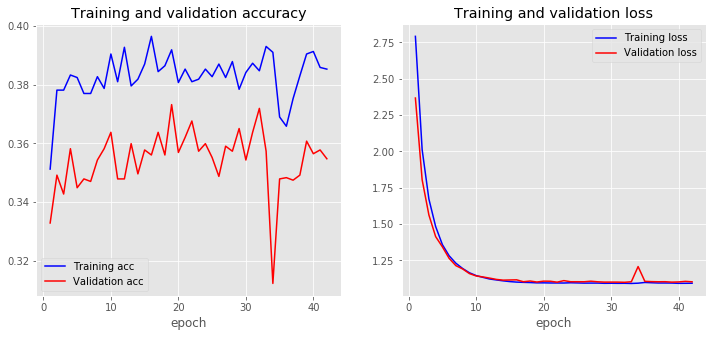

In [58]:
plot_history(cnn_history)

Test on the extra testing set

In [59]:
Counter(cnn.predict_classes(X_test_ex_reshaped))

3396/3396 [==============================] - 0s 77us/step


Counter({0: 2397, 1: 319, 2: 680})

In [60]:
cnn_accuracy = cnn.evaluate(X_test_ex_reshaped, y_test_ex, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

3396/3396 [==============================] - 0s 33us/step
Test accuracy: 21.0836%


### GloVe

Extract word embeddings from the Glove

In [9]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Create a weight matrix

In [11]:
# vocabulary_size=6000

embedding_matrix = np.zeros((6000, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

NameError: name 'tokenizer' is not defined

### GloVe + LSTM

__Note1:__ Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons.  
About Time Distributed layer: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/  A wrapper to wrap LSTM's output  
  
__Note2:__ To solve the problem of LSTM always predicting the same class even when trained with balanced data, the 'return_sequences' param in the LSTM layer needs to be set to True and add a Flatten layer. In addition, 'return_sequences=True' must be set when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input

In [67]:
hidden_nodes = int(2/3 * (n_features * max_sequence_len))
print(f"The number of hidden nodes is {hidden_nodes}.")

The number of hidden nodes is 6666.


In [38]:
def build_ConvLSTM(num_classes, vocabulary_size=None, max_sequence_len=None, 
                   optimizer=None, use_glove=None, show=True):
    optimizer = optimizer or 'adam'
    use_glove = use_glove or True
    embedding_size=100
    lstm_output_size=128
    vocabulary_size=vocabulary_size or 6000
    max_sequence_len=100
    
    model = Sequential()
    if use_glove:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_sequence_len,
                            weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=vocabulary_size))
    model.add(Conv1D(filters=256,
                     kernel_size=2,
                     padding='valid',
                     activation='relu',
                     kernel_regularizer=l2(0.01),
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(units=lstm_output_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(64)))
#     model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(32)))
#     model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(16)))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if show:
        print(model.summary())
    return model

In [101]:
glove_epochs=60
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models','text','glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [39]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          600000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 256)           51456     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           197120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 128)           512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 64)            8256      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 64)            33024     
__________

In [103]:
!rm './saved_models/text/glove.weights.best.hdf5'
glove_history=glove.fit(x_train, y_train, validation_split=0.4, epochs=glove_epochs, callbacks=[glove_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/60
3499/3499 [==============================] - 16s 4ms/step - loss: 1.8654 - acc: 0.3670 - val_loss: 1.3356 - val_acc: 0.3586
Epoch 2/60
3499/3499 [==============================] - 13s 4ms/step - loss: 1.2316 - acc: 0.3933 - val_loss: 1.1857 - val_acc: 0.3513
Epoch 3/60
3499/3499 [==============================] - 13s 4ms/step - loss: 1.1540 - acc: 0.3858 - val_loss: 1.1548 - val_acc: 0.3586
Epoch 4/60
3499/3499 [==============================] - 12s 3ms/step - loss: 1.1248 - acc: 0.4024 - val_loss: 1.1478 - val_acc: 0.3586
Epoch 5/60
3499/3499 [==============================] - 13s 4ms/step - loss: 1.1126 - acc: 0.4113 - val_loss: 1.1312 - val_acc: 0.3822
Epoch 6/60
3499/3499 [==============================] - 12s 4ms/step - loss: 1.1015 - acc: 0.4238 - val_loss: 1.1174 - val_acc: 0.4023
Epoch 7/60
3499/3499 [==============================] - 12s 4ms/step - loss: 1.0982 - acc: 0.4218 - val_loss: 1.1210 - val_acc: 0.4126
Epoch 8

Load the best model from save

In [104]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True, show=False)
glove.load_weights(os.path.join(os.getcwd(),'saved_models','text','glove.weights.best.hdf5'))

In [105]:
y_pred_glove = glove.predict_classes(x_test)
Counter(y_pred_glove)

2874/2874 [==============================] - 4s 1ms/step


Counter({2: 1868, 0: 835, 1: 171})

In [106]:
glove_accuracy = glove.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % glove_accuracy)

2874/2874 [==============================] - 2s 617us/step
Test accuracy: 39.8747%


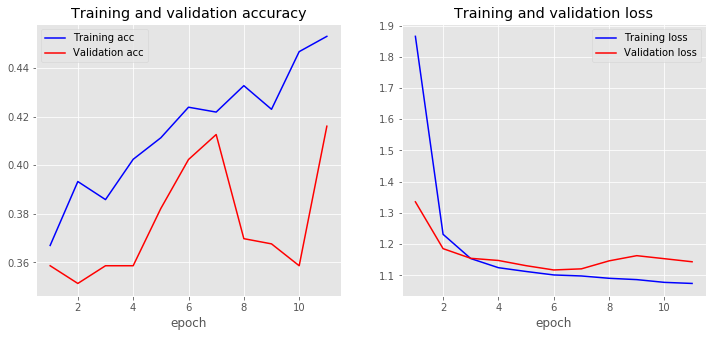

In [109]:
plot_history(glove_history)

Test on the extra test set

In [110]:
Counter(glove.predict_classes(X_test_ex))

3393/3393 [==============================] - 4s 1ms/step


Counter({0: 1014, 2: 2093, 1: 286})

In [111]:
glove_accuracy_ex = glove.evaluate(X_test_ex, y_test_ex, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % glove_accuracy_ex)

3393/3393 [==============================] - 1s 338us/step
Test accuracy: 13.4984%


In [63]:
print('Fully-Connected:',Counter(dense.predict_classes(X_test_ex)))
print('      CNN      :',Counter(cnn.predict_classes(X_test_ex_reshaped)))
print('LSTM with GloVe:',Counter(glove.predict_classes(X_test_ex)))
print('where',sen_label_map)

Fully-Connected: Counter({0: 2225, 2: 963, 1: 188})
      CNN      : Counter({0: 2482, 2: 893, 1: 1})
LSTM with GloVe: Counter({0: 2284, 2: 998, 1: 94})
where {'negative': 0, 'neutral': 1, 'positive': 2}
